In [7]:
import datetime as dt

from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt

%matplotlib inline
wmf.charting.set_mpl_style()

In [3]:
FILE = "metrics/metrics.tsv"

# Data loading and transformation

In [6]:
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

# Calculate other non-bot edits
# This somewhat incorrectly assumes that no mobile edits are data or upload edits 
# (or bot edits, but that's probably nearly correct). We won't be able to feasibly
# correct this until the data lake contains edit tags.
metrics["other_nonbot_edits"] = metrics["nonbot_nondata_nonupload_edits"] - metrics["mobile_edits"]

# Drop columns that aren't key metrics
metrics = metrics.drop(["nonbot_nondata_nonupload_edits"], axis=1)

# Transform content counts into content change
def stock_to_flow(arr):
    return arr[-1] - arr[0]

flow_cols = [
    "net_new_content_pages", 
    "net_new_Wikipedia_articles", 
    "net_new_Commons_content_pages", 
    "net_new_Wikidata_entities"
]
stock_cols = [
    "content_pages", 
    "Wikipedia_articles", 
    "Commons_content_pages",
    "Wikidata_entities"
]

name_map = {flow_cols[i]: stock_cols[i] for i in range(len(stock_cols))}

stock_metrics = metrics[flow_cols].cumsum().rename(name_map, axis=1)

metrics = pd.concat([metrics, stock_metrics], axis=1)

# Show results
metrics.tail()

,active_editors,data_edits,existing_active_editors,mobile_edits,net_new_Commons_content_pages,net_new_Wikidata_entities,net_new_Wikipedia_articles,net_new_content_pages,new_active_editors,new_editor_retention,revert_rate,second_month_active_editors,total_edits,uploads,other_nonbot_edits,content_pages,Wikipedia_articles,Commons_content_pages,Wikidata_entities
month,,,,,,,,,,,,,,,,,,,
2018-06-01,78549.0,16473924.0,59034.0,1128001.0,569621,577595,177203,1638254,15005.0,0.051513,0.076353,3664.0,37115031.0,604437.0,11867237.0,187371864,48374295,47792927,48995598
2018-07-01,77734.0,14115389.0,59386.0,1169233.0,631394,458593,221459,1809947,14037.0,0.056814,0.076803,3455.0,36942656.0,665106.0,12216349.0,189181811,48595754,48424321,49454191
2018-08-01,78681.0,18257565.0,60371.0,1226835.0,763082,520235,221579,1818411,14018.0,0.066411,0.069798,3433.0,40969220.0,799857.0,12661827.0,191000222,48817333,49187403,49974426
2018-09-01,82084.0,17810116.0,59265.0,1171268.0,800330,377222,185644,1635067,18284.0,NaN,0.076115,3671.0,38588449.0,835420.0,12268015.0,192635289,49002977,49987733,50351648
2018-10-01,82567.0,23090068.0,60815.0,1231434.0,549132,1147804,191087,2101982,16690.0,NaN,0.073543,4251.0,43471807.0,588857.0,12150759.0,194737271,49194064,50536865,51499452


# Report

In [8]:
def fmt_num(x):
    if isinstance(x, Number):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def find_latest(ser):
    nn_ser = ser[~ser.isnull()]
    return nn_ser.index[-1].date()

def calc_rpt(ser):
    nn_ser = ser[~ser.isnull()]
    cur_mo = nn_ser.index[-1].date()
    cur = nn_ser[-1]
    mo_prev = nn_ser[-2]
    yr_prev = nn_ser[-13]
    mom_change = (cur / mo_prev) - 1
    yoy_change = (cur / yr_prev) - 1
    
    res = [cur_mo, cur, mom_change, yoy_change]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["latest_month", "value", "mom_change", "yoy_change"]
    )

In [9]:
metrics.apply(calc_rpt).transpose()

,latest_month,value,mom_change,yoy_change
active_editors,2018-10-01,"82,600",0.6%,1.8%
data_edits,2018-10-01,"23,100,000",29.6%,37.4%
existing_active_editors,2018-10-01,"60,800",2.6%,2.0%
mobile_edits,2018-10-01,"1,230,000",5.1%,23.2%
net_new_Commons_content_pages,2018-10-01,"549,000",-31.4%,-4.0%
net_new_Wikidata_entities,2018-10-01,"1,150,000",204.0%,21.9%
net_new_Wikipedia_articles,2018-10-01,"191,000",2.9%,2.8%
net_new_content_pages,2018-10-01,"2,100,000",28.6%,11.4%
new_active_editors,2018-10-01,"16,700",-8.7%,1.1%
new_editor_retention,2018-08-01,6.6%,16.9%,13.3%


##### Graphs

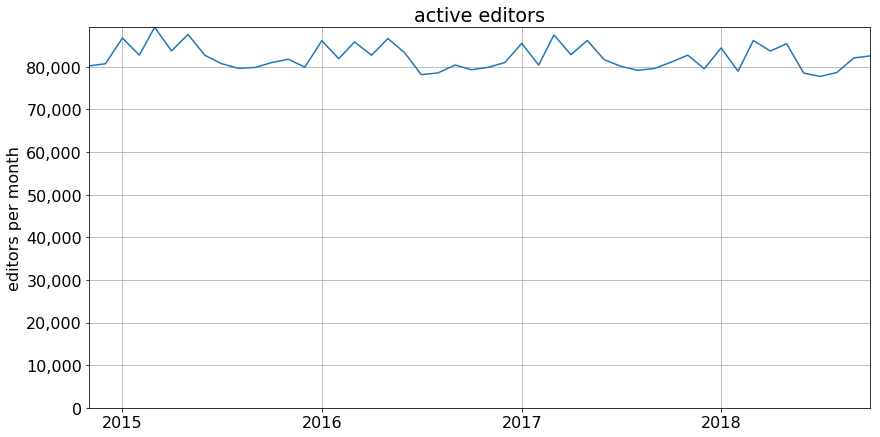

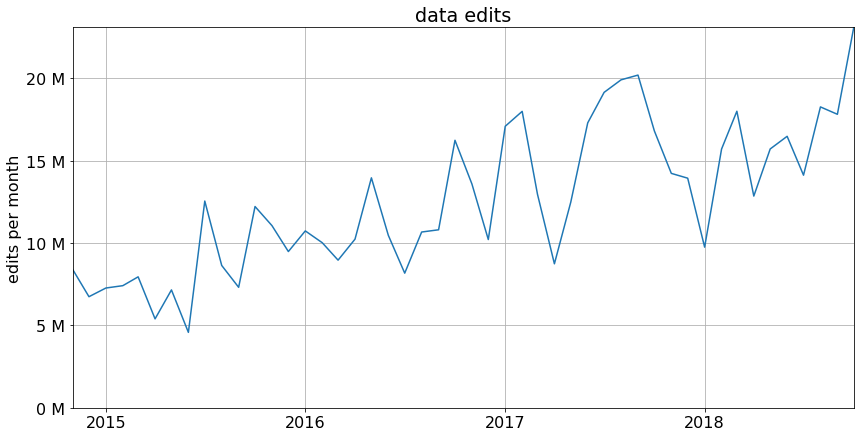

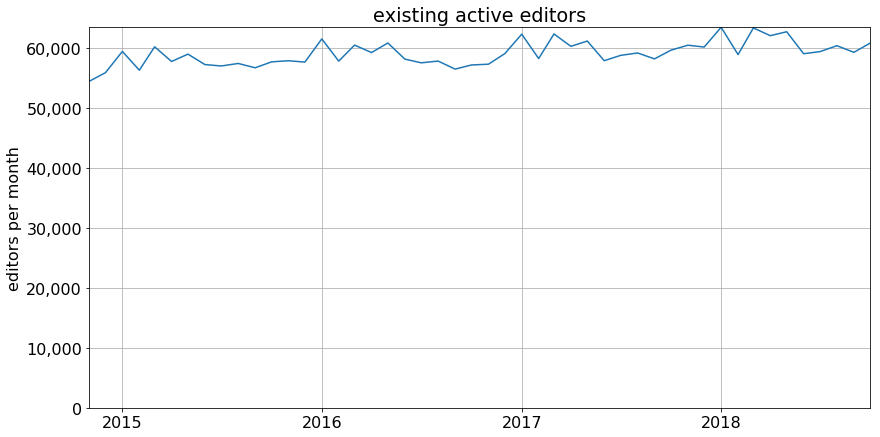

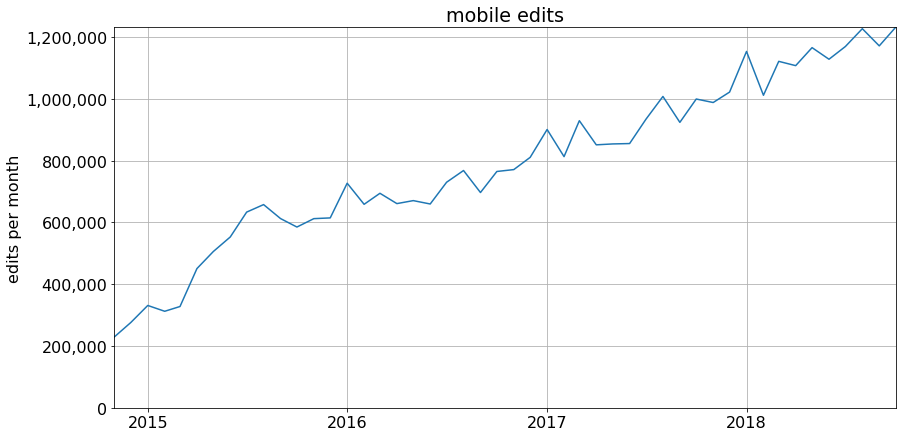

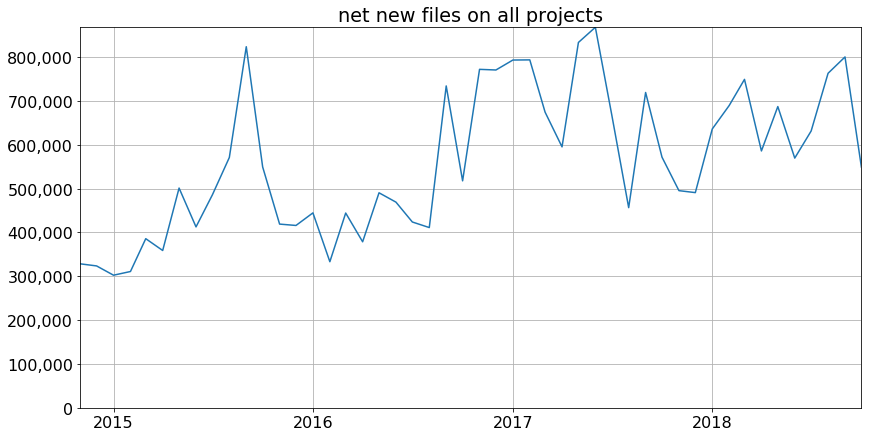

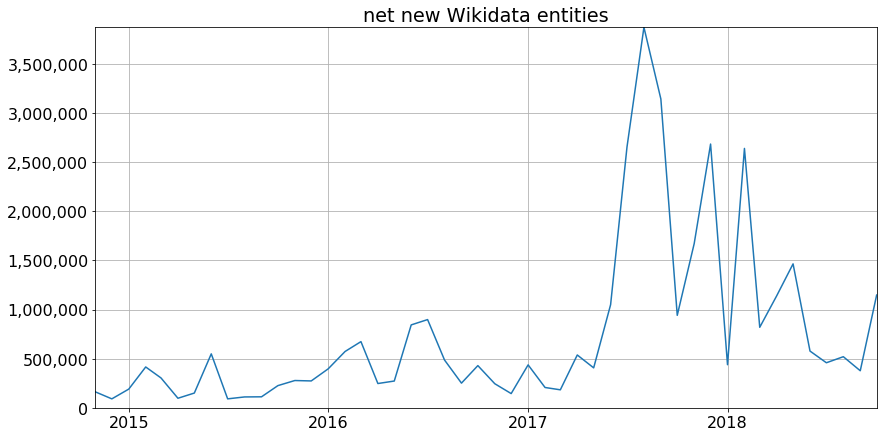

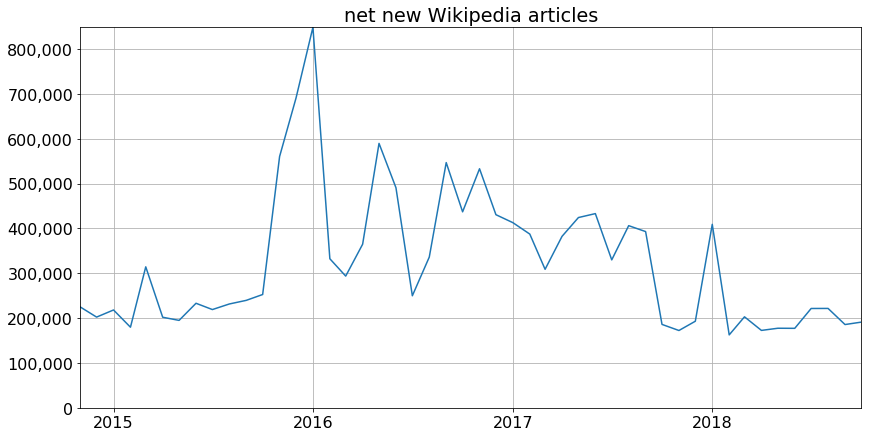

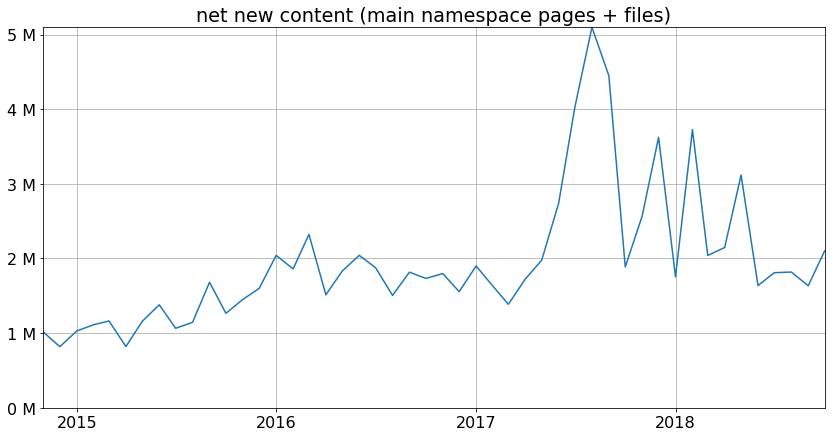

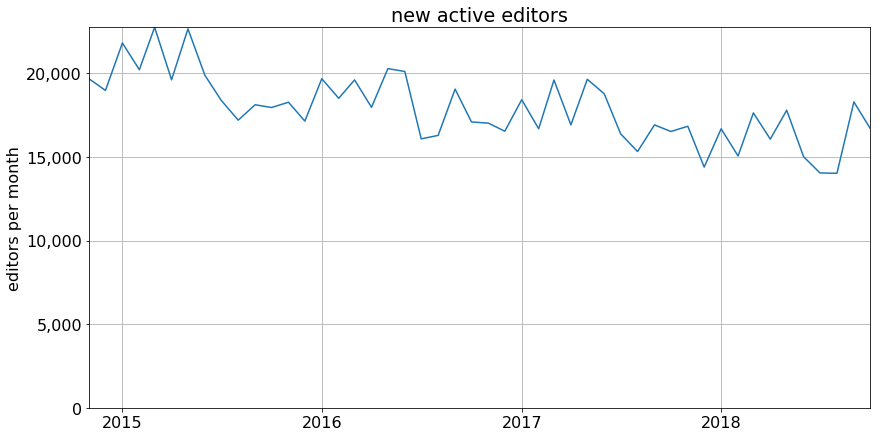

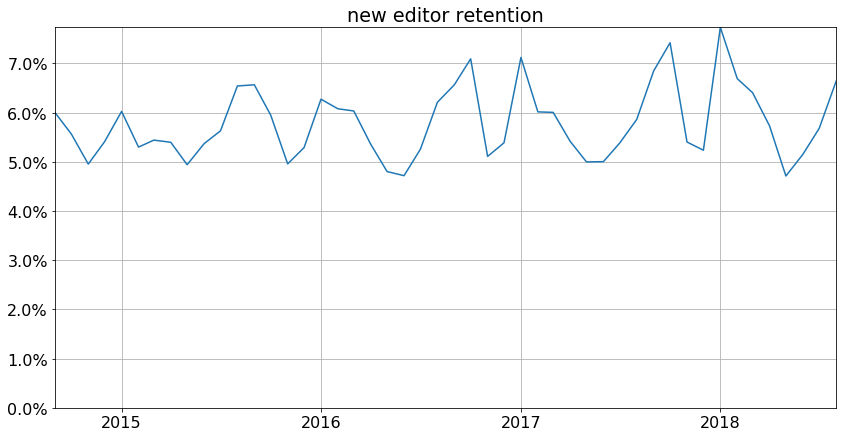

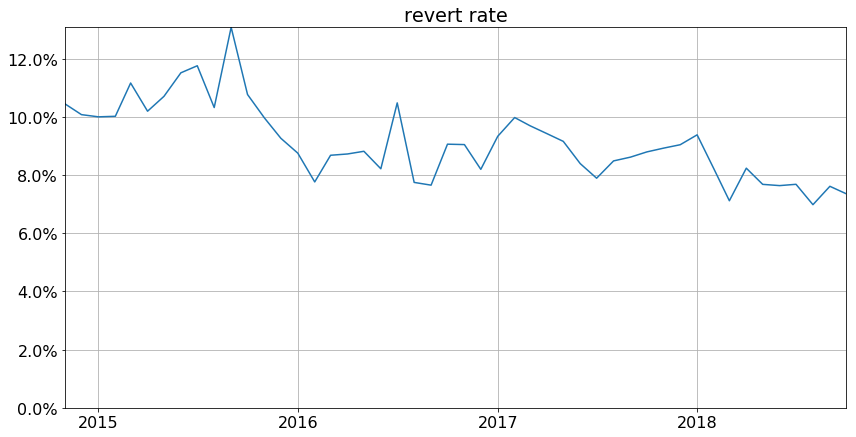

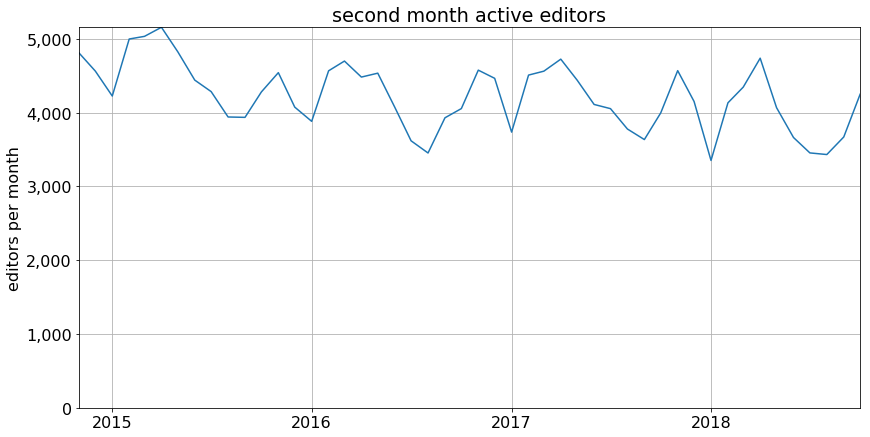

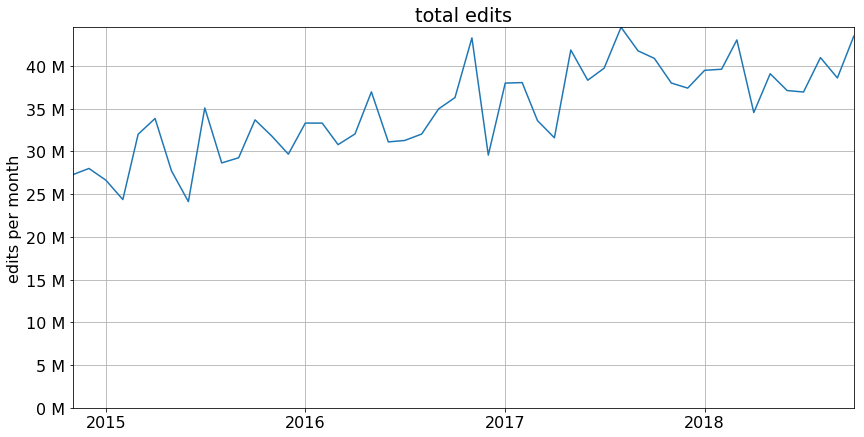

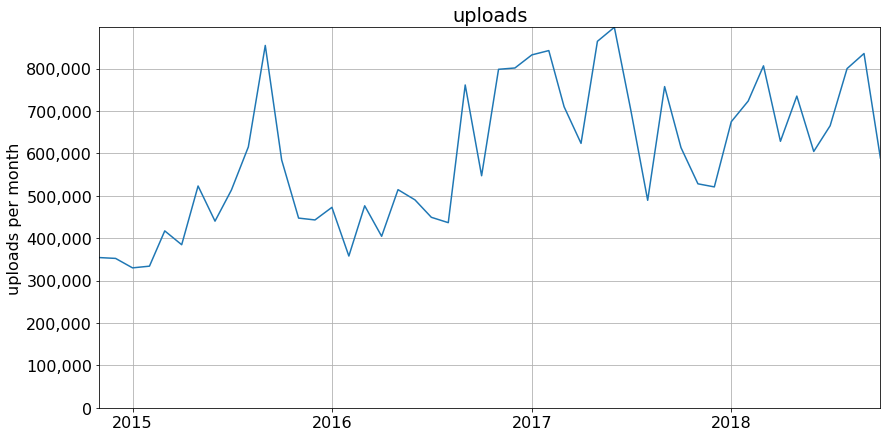

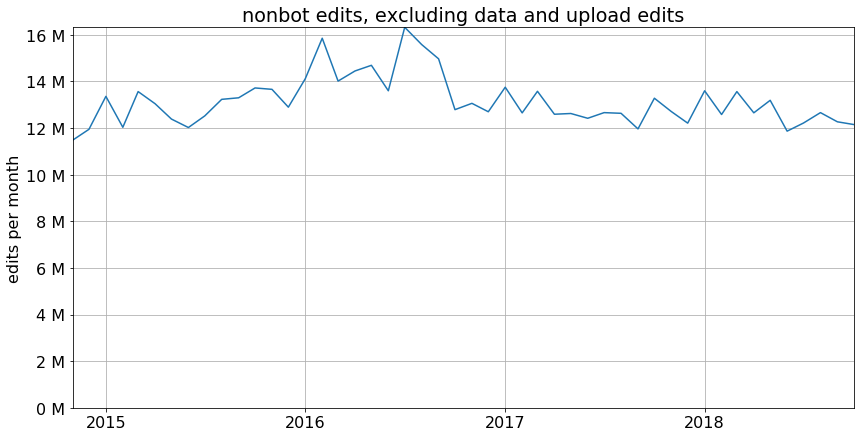

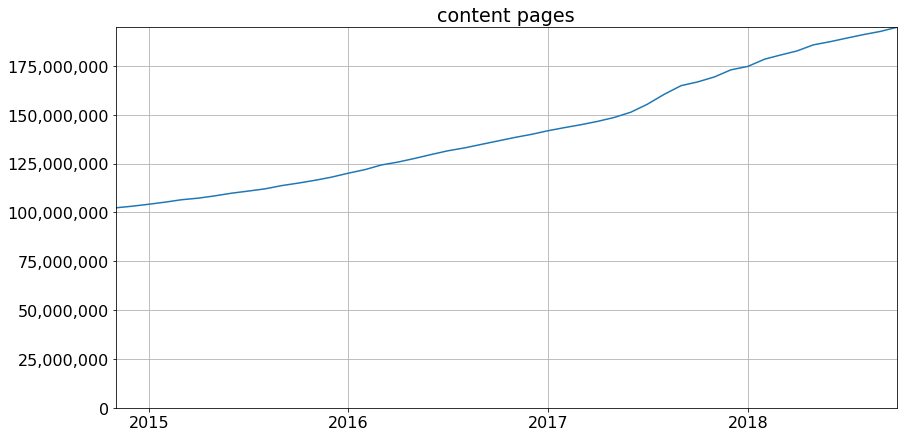

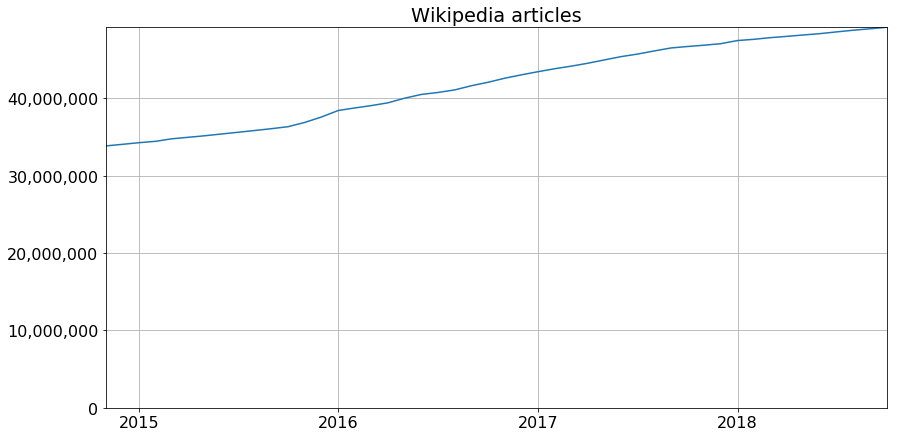

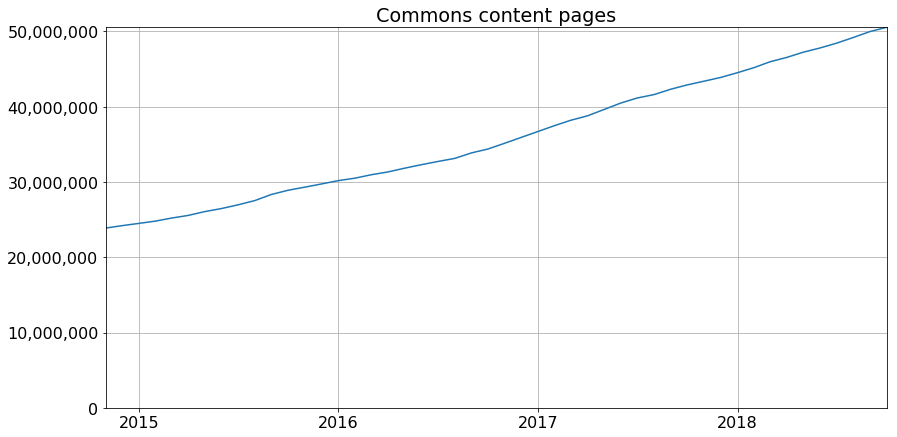

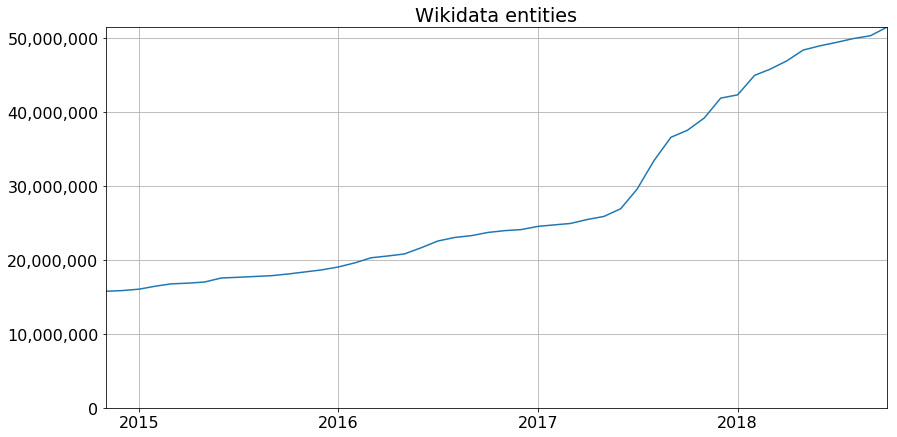

In [10]:
graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "mobile_edits": {
        "y_lab": "edits per month"
    },
    "other_nonbot_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month",
        "title": "nonbot edits, excluding data and upload edits"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt
    },
    "revert_rate": {
        "y_fmt": pct_fmt
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "net_new_content_pages": {
        "y_fmt": M_fmt,
        "title": "net new content (main namespace pages + files)"
    },
    "net_new_Wikipedia_articles": {
    },
    "net_new_Commons_content_pages": {
        "title": "net new files on all projects"
    },
    "net_new_Wikidata_entities": {
    }
}

for name, col in metrics.iteritems():
    cfg = graph_cfg.get(name, {})
    plt.figure()

    end = find_latest(col)
    start = end - relativedelta(months = 47)
    plt.plot(col[start:end])

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.gca().xaxis.set_major_locator(mpl.dates.YearLocator())
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
        
    plt.ylim(ymin=0)
    plt.autoscale(enable=True, axis="x", tight=True)